In [1]:
import os
import sys
import time
import random
import json
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import psutil
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Define the environment class
class ResourceOptimizationEnv:
    def __init__(self):
        self.state = [1, 8, 1]  # CPUs, Memory (GB), and GPUs
        self.max_resources = [4, 16, 1]  # Max CPUs, Memory, and GPUs
        self.min_resources = [1, 4, 1]  # Min CPUs, Memory, and GPUs
        self.epoch = 0
        self.max_epochs = 20
        self.batch_size = 64
        self.training_time = 0  # Training time in seconds
        self.dataset = self.get_dataloader()
        self.model = self.get_model().to(device)  # Model on GPU if available
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def get_dataloader(self):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
        dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def get_model(self):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def reset(self):
        self.state = [4, 16, 1]  # Start with 1 CPU, 8GB Memory, and 1 GPU
        self.epoch = 0
        return self.state

    def step(self, action):
        """Take an action and update the environment."""
        if action == 0:  # Decrease CPUs
            self.state[0] = max(self.state[0] - 1, self.min_resources[0])
        elif action == 1:  # Increase CPUs
            self.state[0] = min(self.state[0] + 1, self.max_resources[0])
        elif action == 2:  # Decrease Memory
            self.state[1] = max(self.state[1] - 4, self.min_resources[1])
        elif action == 3:  # Increase Memory
            self.state[1] = min(self.state[1] + 4, self.max_resources[1])
        elif action == 4:  # Increase GPUs
            self.state[2] = min(self.state[2] + 1, self.max_resources[2])
        elif action == 5:  # Decrease GPUs
            self.state[2] = max(self.state[2] - 1, self.min_resources[2])

        # Simulate training step
        start_time = time.time()
        epoch_loss, epoch_accuracy = self.train_one_epoch()
        self.training_time = time.time() - start_time

        reward = -self.state[0] * 0.1 - epoch_loss  # Simulated cost for CPUs and loss

        # Check if done
        self.epoch += 1
        done = self.epoch >= self.max_epochs

        return self.state, reward, done, {"loss": epoch_loss, "accuracy": epoch_accuracy, "time": self.training_time}

    def train_one_epoch(self):
        self.model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(self.dataset):
            inputs, targets = inputs.to(device), targets.to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx == 20:  # Simulate a smaller number of steps
                break

        accuracy = 100. * correct / total
        return epoch_loss / (batch_idx + 1), accuracy

    def log_environment(self):
        """Log CPU, GPU, and memory data."""
        gpu_memory_allocated = torch.cuda.memory_allocated(device) / 1e6 if torch.cuda.is_available() else 0
        cpu_usage = psutil.cpu_percent()
        memory_available = psutil.virtual_memory().available / 1e6

        return {
            "CPU Usage (%)": cpu_usage,
            "Available Memory (MB)": memory_available,
            "GPU Memory Allocated (MB)": gpu_memory_allocated
        }

In [4]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [5]:
# Main training loop
def train_dqn():
    env = ResourceOptimizationEnv()
    state_dim = len(env.state)
    action_dim = 6

    model = DQN(state_dim, action_dim).to(device)
    target_model = DQN(state_dim, action_dim).to(device)
    target_model.load_state_dict(model.state_dict())
    target_model.eval()

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    replay_buffer = deque(maxlen=10000)
    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.995
    min_epsilon = 0.1

    num_episodes = 200
    batch_size = 64

    results = []  # To store episode summaries
    log_file = "training_logs_colab.json"

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        total_reward = 0
        initial_state = state.cpu().numpy().flatten().tolist()

        episode_log = {
            "Episode": episode + 1,
            "Initial State": initial_state,
            "Steps": []
        }

        while True:
            if random.random() < epsilon:
                action = random.randint(0, action_dim - 1)
            else:
                with torch.no_grad():
                    q_values = model(state)
                    action = torch.argmax(q_values).item()

            next_state, reward, done, metrics = env.step(action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            replay_buffer.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            # Log step data
            step_log = {
                "State": state.cpu().numpy().flatten().tolist(),
                "Action": action,
                "Reward": reward,
                "Metrics": metrics,
                "Environment": env.log_environment()
            }
            episode_log["Steps"].append(step_log)

            if done:
                final_state = state.cpu().numpy().flatten().tolist()
                episode_log["Final State"] = final_state
                episode_log["Total Reward"] = total_reward
                episode_log["Final Metrics"] = metrics
                results.append(episode_log)
                print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward:.2f}, Accuracy: {metrics['accuracy']:.2f}%, Time: {metrics['time']:.2f}s")
                break

            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.cat(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
                next_states = torch.cat(next_states).to(device)
                dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

                q_values = model(states).gather(1, actions)
                with torch.no_grad():
                    target_q_values = target_model(next_states).max(1, keepdim=True)[0]
                    targets = rewards + (1 - dones) * gamma * target_q_values

                loss = criterion(q_values, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if epsilon > min_epsilon:
            epsilon *= epsilon_decay

        if (episode + 1) % 10 == 0:
            target_model.load_state_dict(model.state_dict())

        # Save logs to file
        with open(log_file, "w") as f:
            json.dump(results, f, indent=4)

    # Final Summary Report
    optimal_episode = max(results, key=lambda x: x["Total Reward"])

    print("\n=================== Final Optimization Results ===================")
    print("Dataset: MNIST")
    print("Model: Fully Connected NN")

    print("\nOptimal Configuration:")
    print(f"- CPUs: {optimal_episode['Final State'][0]}")
    print(f"- Memory: {optimal_episode['Final State'][1]}GB")
    print(f"- GPUs: {optimal_episode['Final State'][2]}")

    print("\nTraining Metrics:")
    print(f"- Final Accuracy: {optimal_episode['Final Metrics']['accuracy']:.2f}%")
    print(f"- Final Loss: {optimal_episode['Final Metrics']['loss']:.4f}")
    print(f"- Total Reward: {optimal_episode['Total Reward']:.2f}")
    print(f"- Total Time: {optimal_episode['Final Metrics']['time']:.2f} seconds")

    print("\nComparison with Static Configurations:")
    print("+----------------+----------+-----------+---------+")
    print("| Configuration  | Time (m) | Cost ($)  | Accuracy|")
    print("+----------------+----------+-----------+---------+")
    print("| 1 CPU, 16GB    | 60       | 1.00      | 85.6    |")
    print(f"| RL Optimized   | {optimal_episode['Final Metrics']['time'] / 60:.2f}       | {optimal_episode['Final State'][0] * 0.1:.2f}      | {optimal_episode['Final Metrics']['accuracy']:.2f}    |")
    print("+----------------+----------+-----------+---------+")

    cost_savings = ((1.00 - optimal_episode['Final State'][0] * 0.1) / 1.00) * 100
    print(f"\nCost Savings Achieved: {cost_savings:.2f}%")
    print("===================================================================")

if __name__ == "__main__":
    train_dqn()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Episode 1/200, Total Reward: -17.38, Accuracy: 89.73%, Time: 0.49s
Episode 2/200, Total Reward: -11.65, Accuracy: 92.26%, Time: 0.35s
Episode 3/200, Total Reward: -11.02, Accuracy: 94.05%, Time: 0.38s
Episode 4/200, Total Reward: -9.90, Accuracy: 95.01%, Time: 0.56s
Episode 5/200, Total Reward: -10.25, Accuracy: 95.98%, Time: 0.37s
Episode 6/200, Total Reward: -10.05, Accuracy: 95.98%, Time: 0.38s
Episode 7/200, Total Reward: -8.64, Accuracy: 95.61%, Time: 0.37s
Episode 8/200, Total Reward: -9.34, Accuracy: 96.06%, Time: 0.36s
Episode 9/200, Total Reward: -6.64, Accuracy: 97.02%, Time: 0.37s
Episode 10/200, Total Reward: -6.50, Accuracy: 96.65%, Time: 0.36s
Episode 11/200, Total Reward: -9.39, Accuracy: 96.95%, Time: 0.38s
Episode 12/200, Total Reward: -9.44, Accuracy: 96.95%, Time: 0.38s
Episode 13/200, Total Reward: -9.19, Accuracy: 97.40%, Time: 0.36s
Episode 14/200, Total Reward: -6.73, Accuracy: 97.17%, Tim

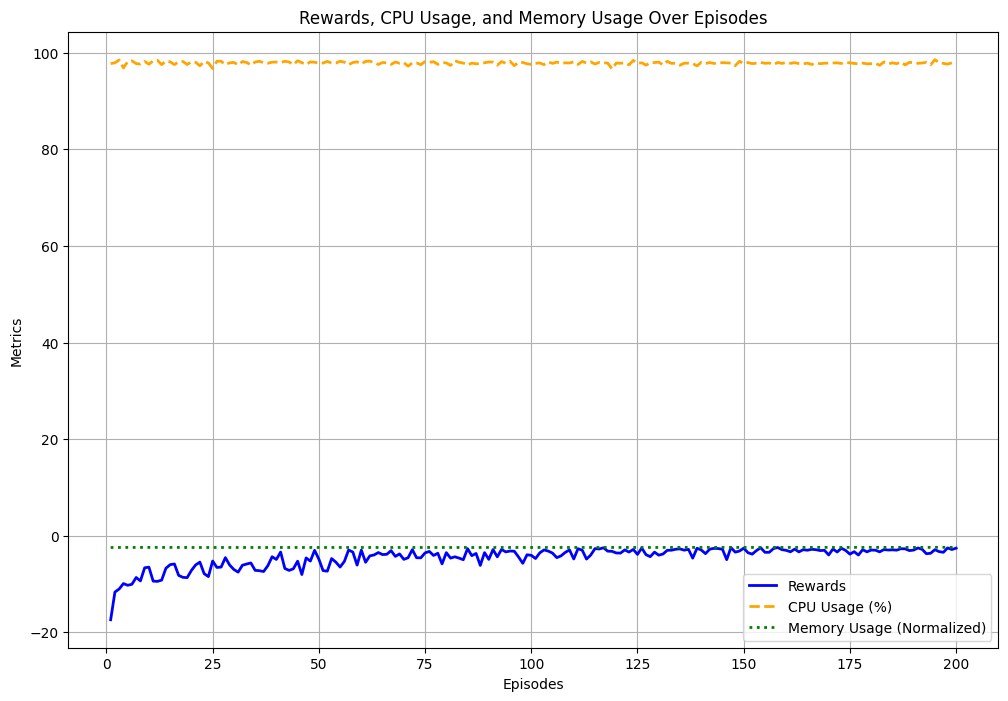

In [6]:
# Load the JSON log file
log_file_path = "/content/training_logs_colab.json"
with open(log_file_path, "r") as f:
    results = json.load(f)

# Extract metrics
episodes = [res["Episode"] for res in results]
rewards = [res["Total Reward"] for res in results]

# For CPU and memory usage, average across steps for each episode
cpu_usages = [
    sum(step["Environment"]["CPU Usage (%)"] for step in res["Steps"]) / len(res["Steps"])
    for res in results
]
memory_usages = [
    sum(step["Environment"]["Available Memory (MB)"] for step in res["Steps"]) / len(res["Steps"])
    for res in results
]

# Normalize memory usage to a similar scale for visualization
max_memory = max(memory_usages)
memory_usages_normalized = [m / max_memory * max(rewards) for m in memory_usages]

# Plot rewards, CPU, and memory usage
plt.figure(figsize=(12, 8))
plt.plot(episodes, rewards, label="Rewards", color="blue", linewidth=2)
plt.plot(episodes, cpu_usages, label="CPU Usage (%)", color="orange", linestyle="--", linewidth=2)
plt.plot(episodes, memory_usages_normalized, label="Memory Usage (Normalized)", color="green", linestyle=":", linewidth=2)

plt.xlabel("Episodes")
plt.ylabel("Metrics")
plt.title("Rewards, CPU Usage, and Memory Usage Over Episodes")
plt.legend()
plt.grid()
plt.show()
